#BASE DE DATOS HISTORICA DE ACCIONES MDTR


In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

1. Se importan las bibliotecas necesarias, como TensorFlow (para aprendizaje automático), NumPy (para operaciones matemáticas), Matplotlib (para gráficos), Seaborn (para mejorar la visualización), Pandas (para manejo de datos), y algunas otras bibliotecas específicas.

2. Tambien se configura una semilla para TensorFlow (tf.random.set_seed(1234)) para asegurarse de obtener resultados reproducibles cuando se utiliza TensorFlow.

3. Por ultimo se carga datos financieros de MDTR desde un archivo CSV ubicado en Drive , en un DataFrame de Pandas llamado 'df'.





In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
df = pd.read_csv('../content/drive/MyDrive/BD/MDTR.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-10,62.480000,63.740002,60.889999,61.439999,60.821850,1041900
1,2022-10-11,60.130001,61.689999,58.959999,60.090000,59.485435,1166700
2,2022-10-12,59.700001,62.080002,59.049999,61.639999,61.019840,1449200
3,2022-10-13,60.310001,63.860001,59.799999,63.500000,62.861130,1376700
4,2022-10-14,62.349998,63.200001,59.860001,60.049999,59.445839,950500


Se realizara  un escalado Min-Max en los datos de precios de cierre de acciones en un DataFrame llamado 'df'.  Se utilizara MinMaxScaler para ajustar y transformar estos valores a un rango de 0 a 1, guardando el resultado en un nuevo DataFrame llamado 'df_log'. El escalado Min-Max es una técnica común en el preprocesamiento de datos financieros y es útil para asegurar que los datos estén en una escala uniforme, lo que puede mejorar el rendimiento de los modelos de aprendizaje automático.

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.614913
1,0.571336
2,0.621369
3,0.681407
4,0.570045


Este código divide el conjunto de datos 'df_log' en dos subconjuntos: uno de entrenamiento ('df_train') que contiene la mayoría de los datos, y otro de prueba ('df_test') con los últimos 30 registros. Estos conjuntos se utilizan para entrenar y evaluar modelos de aprendizaje automático.

#####RESULTADO: El primer valor, (253, 7), corresponde al DataFrame original 'df', que tiene 253 filas y 7 columnas.

 El segundo valor, (223, 1), es para 'df_train', el conjunto de entrenamiento, que contiene 223 filas y 1 columna.

El tercer valor, (30, 1), corresponde a 'df_test', el conjunto de prueba, que consta de 30 filas y 1 columna.





In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

Se define la funcion  Model que representa un modelo de red neuronal donde tiene un constructor __init__ que acepta varios parámetros relacionados con la configuración del modelo, como la tasa de aprendizaje, el número de capas, el tamaño de las capas, el tamaño de la salida y un sesgo de olvido.Dentro del constructor, se crea una red neuronal RNN utilizando celdas LSTM.

El modelo calcula una función de costo   y utiliza el optimizador Adam para minimizar este costo.Luego, hay una función calculate_accuracy que calcula la precisión del modelo en función de las predicciones y los valores reales.La función anchor realiza una suavización exponencial ponderada en una serie temporal utilizando un parámetro de peso.

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

Estos valores de parámetros configuran el modelo de predicción de series temporales: una sola capa en la red, capas con 128 unidades, una ventana de tiempo de 5 pasos, 300 iteraciones de entrenamiento, una tasa de abandono del 80%, y se espera predecir un número de días igual al tamaño del conjunto de prueba 30 días, todo con una tasa de aprendizaje de 0.01. Estos parámetros afectan cómo el modelo aprende y realiza predicciones en una serie temporal.

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

La función forecast define un modelo  para predecir valores en una serie temporal. El modelo se entrena en múltiples épocas utilizando ventanas de datos de entrenamiento y luego se utiliza para hacer predicciones en la serie temporal. Las predicciones se almacenan en output_predict, se escalan inversamente y se suavizan antes de devolver una serie temporal de predicciones futuras que coincide con el tamaño del conjunto de prueba.

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from tqdm import tqdm

def forecast():
    model = Sequential()
    model.add(LSTM(size_layer, input_shape=(timestamp, df_log.shape[1]), return_sequences=True))
    model.add(LSTM(size_layer, return_sequences=True))
    model.add(Dense(df_log.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')

    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
          index = min(k + timestamp, df_train.shape[0] - 1)
          batch_x = np.zeros((1, 5, 1))
          batch_x[0, :index - k, 0] = df_train.iloc[k : index, :].values.reshape(-1)
          batch_y = np.zeros((1, 5, 1))
          batch_y[0, :index - k, 0] = df_train.iloc[k + 1 : index + 1, :].values.reshape(-1)
          loss = model.train_on_batch(batch_x, batch_y)
          total_loss.append(loss)
          pbar.set_postfix(cost=np.mean(total_loss))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0].values
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = model.predict(df_train.iloc[k : k + timestamp, :].values.reshape(1, timestamp, -1))
        output_predict[k + 1 : k + timestamp + 1] = out_logits[0]

    if upper_b != df_train.shape[0]:
        out_logits = model.predict(df_train.iloc[upper_b:, :].values.reshape(1, df_train.shape[0] - upper_b, -1))
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits[0]
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    init_value = out_logits[0]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = model.predict(o.reshape(1, timestamp, -1))
        # Almacena solo la última predicción en la posición adecuada
        output_predict[-future_day + i, 0] = out_logits[0, -1, 0]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

Aca se ejecuta la función forecast en un bucle para realizar múltiples simulaciones de predicción de series temporales. Los resultados de cada simulación se almacenan en la lista results. Cada iteración del bucle representa una simulación independiente de predicción en la serie temporal utilizando el modelo definido anteriormente. Las predicciones resultantes se acumulan en la lista results para su posterior análisis o visualización.

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|██████████| 300/300 [05:09<00:00,  1.03s/it, cost=0.00319]


1/1 [==============================] - 0s 23ms/step
simulation 2


train loop: 100%|██████████| 300/300 [05:06<00:00,  1.02s/it, cost=0.00315]


1/1 [==============================] - 0s 25ms/step
simulation 3


train loop: 100%|██████████| 300/300 [05:06<00:00,  1.02s/it, cost=0.00317]


1/1 [==============================] - 0s 22ms/step
simulation 4


train loop: 100%|██████████| 300/300 [05:05<00:00,  1.02s/it, cost=0.00321]


1/1 [==============================] - 0s 22ms/step
simulation 5


train loop: 100%|██████████| 300/300 [05:13<00:00,  1.04s/it, cost=0.0032]


1/1 [==============================] - 0s 22ms/step
simulation 6


train loop: 100%|██████████| 300/300 [05:09<00:00,  1.03s/it, cost=0.00323]


1/1 [==============================] - 0s 39ms/step
simulation 7


train loop: 100%|██████████| 300/300 [05:08<00:00,  1.03s/it, cost=0.00324]


1/1 [==============================] - 0s 27ms/step
simulation 8


train loop: 100%|██████████| 300/300 [05:18<00:00,  1.06s/it, cost=0.00321]


1/1 [==============================] - 0s 37ms/step
simulation 9


train loop: 100%|██████████| 300/300 [05:10<00:00,  1.04s/it, cost=0.00325]


1/1 [==============================] - 0s 22ms/step
simulation 10


train loop: 100%|██████████| 300/300 [05:25<00:00,  1.08s/it, cost=0.00319]


1/1 [==============================] - 0s 27ms/step


 Se visualiza la precisión de las predicciones realizadas por las simulaciones en comparación con los valores reales de la serie temporal, lo que permite evaluar el rendimiento del modelo en la predicción de la tendencia de la serie temporal.

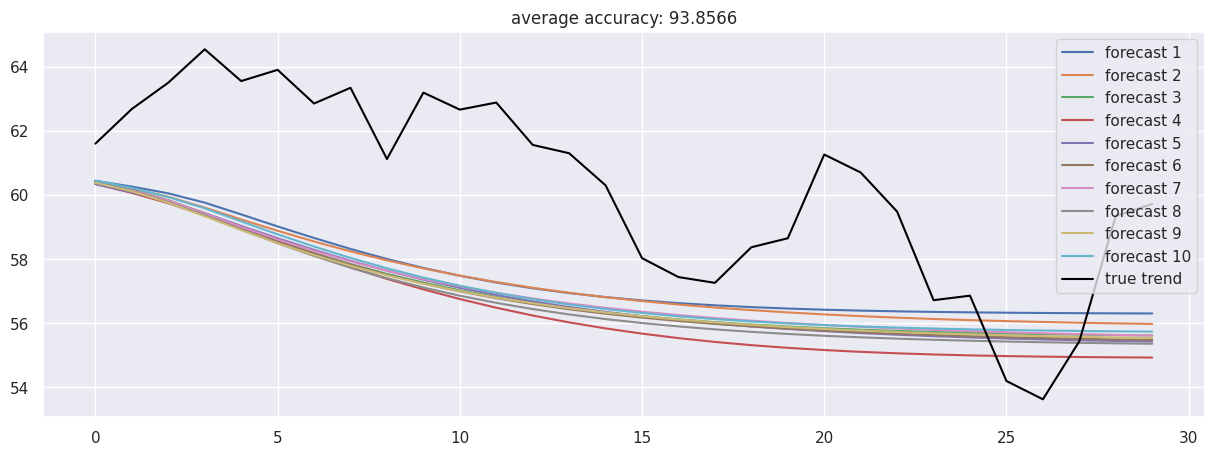

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

El valor promedio de precisión de 93.8566 en este contexto significa que el modelo tiende a predecir los valores reales con una alta precisión, lo que es un indicativo de que las predicciones son confiables y útiles. Esta alta precisión es deseable en aplicaciones de predicción de series temporales,